In [2]:
import numpy as np
import pandas as pd
import random

# Setup plotting with matplotlib
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
## setup latex plotting
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
## make font size bigger
matplotlib.rcParams.update({'font.size': 16})
## but make legend smaller
matplotlib.rcParams.update({'legend.fontsize': 14})
## change line thickness
matplotlib.rcParams.update({'lines.linewidth' : 1.75})

import chirallag as cL

In [3]:
N=3
gens = cL.gen_gellman(3)
F0 = 1



def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
        
liststrucSU3 = np.array([[1,2,3,1],[1,4,7,.5],[1,5,6,-.5],[2,4,6,.5],[2,5,7,.5],[3,4,5,.5],[3,6,7,-.5],[4,5,8,3**0.5/2],[6,7,8,3**0.5/2]])
liststrucSU2 = np.array([[1,2,3,1],[3,2,1,1]])

def adjointSUN(dim,liststruc):
    dimSUN=dim**2-1
#     admat = np.zeros((8,8,8))
    admat = np.zeros((dimSUN,dimSUN,dimSUN))
    for i in range(liststruc.shape[0]):
        strucc = liststruc[i]
        strucc1 = int(strucc[0])-1
        strucc2 = int(strucc[1])-1
        strucc3 = int(strucc[2])-1
        admat[strucc1,strucc2,strucc3]=strucc[3]
        admat[strucc1,strucc3,strucc2]=-strucc[3]
        admat[strucc3,strucc1,strucc2]=strucc[3]
        admat[strucc3,strucc2,strucc1]=-strucc[3]
        admat[strucc2,strucc3,strucc1]=strucc[3]
        admat[strucc2,strucc1,strucc3]=-strucc[3]
    return admat

adjointSU3 = adjointSUN(3,liststrucSU3)

In [4]:
# To do, make these work when not supplying stacks of epsilon and transformations.

def get_SO_trans(eps,N):
    ''' Produces 'infinitesimal' transformation matrices for SO(N) given epsilon.
        Epsilon is size of transformation and should be a numpy array of dimension 1.
        N must be larger than 1.
    '''
    
    trans_number = len(eps) 
    # Generate rotation matrices
    SO_samp = np.zeros((trans_number,N,N))

    # Set random off diagonal element of each matrix to one (surely must be a better way to do this)
    poss_inds = range(N)
    SO_inds = [random.sample(poss_inds,2) for i in range(trans_number)]
    SO_indsflat = [i*(N)**2+x*(N)+y for i,(x,y) in enumerate(SO_inds)]
    SO_samp.flat[SO_indsflat] += 1

    # Is this transpose faster than repeating assignment above?
    SO_samp = SO_samp - np.transpose(SO_samp,axes=[0,2,1])
    SO_trans = np.identity(N) + eps[:,None,None]*SO_samp
    # Normalise so that det = 1
    #norm = np.power(np.linalg.det(SO_trans),-1/(N))
    #SO_trans = norm[:,None,None]*SO_trans
    return SO_trans
  
def get_SU_trans(eps,N,liststruct):
    ''' Produces 'infinitesimal' transformation matrices for SO(N) given epsilon.
        Epsilon is size of transformation and should be a numpy array of dimension 1.
        N must be larger than 1.
        Calls adjointSUN which requires liststruct
    '''
    adjointSU = adjointSUN(N,liststruct)
    
    genno=np.random.randint(0,N*N-2,number_predictions)
    SU_trans = np.identity(N*N-1)+eps[:,None,None]*adjointSU[genno]
    # Normalise so that det = 1
    #norm = np.power(np.linalg.det(SU_trans),-1/(N*N-1))
    #SU_trans = norm[:,None,None]*SU_trans
    return SU_trans
    
def apply_trans(trans,vec):
    ''' Apply transformation trans to vector. Assumes both trans and vec are stacks.'''
    trans_vec=np.matmul(trans,vec[:,:,None]).squeeze()
    return trans_vec
    


In [5]:
# Compare Transformations
epsmax = 100
epsmin = 0.001
eps_intervals=200
number_predictions=100000


pi=np.random.rand(number_predictions,N*N-1)
dpi=np.random.rand(number_predictions,N*N-1)

# Get epsilons, create copies
eps_vals=np.logspace(np.log10(epsmin),np.log10(epsmax),num=eps_intervals)
eps = np.zeros(number_predictions)
for i,val in enumerate(eps_vals): 
    eps[i*int(number_predictions/eps_intervals):(i+1)*int(number_predictions/eps_intervals)] = val
# Set leftovers to max value
eps[(i+1)*int(number_predictions/eps_intervals):]=val

# SO(N) transformations
SO_trans = get_SO_trans(eps,N*N-1)

SO_pi = apply_trans(SO_trans,pi)
SO_dpi = apply_trans(SO_trans,dpi)

# SU(N) transformations

SU_trans = get_SU_trans(eps,N,liststrucSU3)

SU_pi = apply_trans(SU_trans,pi)
SU_dpi = apply_trans(SU_trans,dpi)


# Get potential values, only care about real part (non zero imag should just be numerical precision errors)

orig_V = cL.get_V(pi,dpi,gens,F0).real
SO_V = cL.get_V(SO_pi,SO_dpi,gens,F0).real
SU_V = cL.get_V(SU_pi,SU_dpi,gens,F0).real

SO_Vdiff = SO_V - orig_V
SU_Vdiff = SU_V - orig_V

rand_means = np.mean(np.hstack([np.abs(pi) , np.abs(dpi)]),axis=-1)


In [18]:
np.savetxt('../Training_Data/symetric_training_data_dpi.csv',dpi,delimiter= ',')
np.savetxt('../Training_Data/symetric_training_data_pi.csv',pi,delimiter= ',')
np.savetxt('../Training_Data/symetric_training_data_V.csv',orig_V,delimiter= ',')
np.savetxt('../Training_Data/symetric_training_data_dpi_SO8.csv',SO_dpi,delimiter= ',')
np.savetxt('../Training_Data/symetric_training_data_pi_SO8.csv',SO_pi,delimiter= ',')
np.savetxt('../Training_Data/symetric_training_data_V_SO8.csv',SO_V,delimiter= ',')

In [7]:
print("Average error of SU(3) transformation: ",np.mean(np.abs(SU_Vdiff)),
      ", and of rotation: ",np.mean(np.abs(SO_Vdiff)))

print("Average potential value: ",np.mean(np.abs(orig_V)),", average pion value:",np.mean(rand_means))

Average error of SU(3) transformation:  65502.38325689952 , and of rotation:  16719.91546423429
Average potential value:  0.19442500778688163 , average pion value: 0.5002255581649776


(0.001, 1)

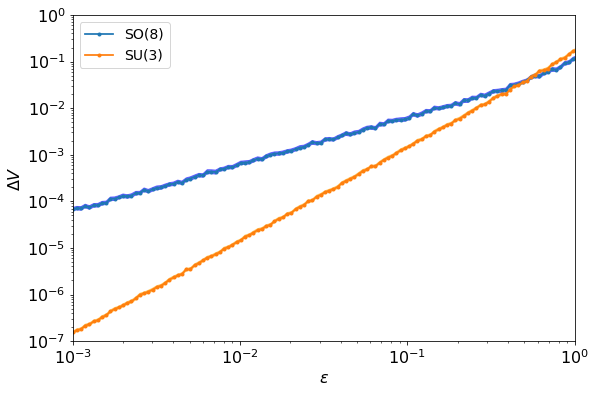

In [8]:
# Standard error by hand to compare with seaborn lineplot

fig,ax = plt.subplots(1,figsize=(9,6))

# Evaluate std deviation is epsilon is created using interval
SO_Vdiff_eps = [np.abs(SO_Vdiff[np.where(eps==val)]) for val in eps_vals]
mean_SO = np.mean(SO_Vdiff_eps,axis=-1)
std_dev_SO = np.std(SO_Vdiff_eps,axis=-1)
std_error_SO = std_dev_SO/np.sqrt([len(s) for s in SO_Vdiff_eps])
SU_Vdiff_eps = [np.abs(SU_Vdiff[np.where(eps==val)]) for val in eps_vals]
mean_SU = np.mean(SU_Vdiff_eps,axis=-1)
std_dev_SU = np.std(SU_Vdiff_eps,axis=-1)
std_error_SU = std_dev_SU/np.sqrt([len(s) for s in SU_Vdiff_eps])
#print(std_dev_SU)

#print(std_error_SU)
ax.plot(eps_vals,mean_SO,marker='.',label='SO({:})'.format(N*N-1))
ax.plot(eps_vals,mean_SU,marker='.',label='SU({:})'.format(N))
ax.fill_between(eps_vals,mean_SO-1.96*std_error_SO, mean_SO+1.96*std_error_SO,color='blue',alpha=0.5)
ax.fill_between(eps_vals,mean_SU-1.96*std_error_SU, mean_SU+1.96*std_error_SU,color='orange',alpha=0.5)

ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\Delta V$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_ylim(1e-7,1)
ax.set_xlim(1e-3,1)

#fig.tight_layout()
#fig.savefig('DeltaV.png',dpi=200)

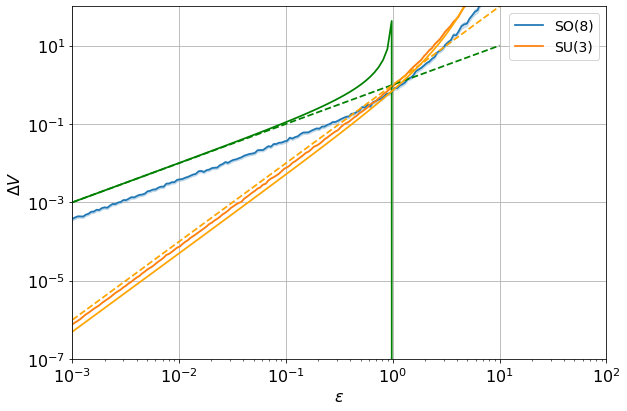

In [9]:
fig,ax = plt.subplots(1,figsize=(9,6))


data = pd.DataFrame({'epsilon':eps,'SOdiff':np.abs(SO_Vdiff/orig_V),'SUdiff':np.abs(SU_Vdiff/orig_V)})
sb.lineplot(data=data,x='epsilon',y='SOdiff',label='SO({:})'.format(N*N-1),ci=95)
sb.lineplot(data=data,x='epsilon',y='SUdiff',label='SU({:})'.format(N),ci=95)

x = np.logspace(-3,1,100)
y1 = np.exp(x)-(1+x)
y = 1/(1-x)-(1)
ax.plot(x,y,color="green")
ax.plot(x,x,color="green",linestyle='--')
ax.plot(x,y1,color="orange")
ax.plot(x,x**2,color="orange",linestyle='--')


ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\Delta V$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
ax.legend()
ax.set_ylim(1e-7,100)
ax.set_xlim(1e-3,100)
fig.tight_layout()
fig.savefig('DeltaV.jpeg',dpi=200,transparent=False)

In [10]:
data.to_csv('../Training_Data/symetric_training_data_epsilon_and_vdiff.csv')